# Throughput

## Import Data

In [1]:
import json
import os, glob
import pandas as pd
import pandas.io.json as pdjson
import seaborn as sns

sns.set(style="whitegrid")

In [2]:
data_frames = []

for file in glob.glob("*.orun.bench"):
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        df = pdjson.json_normalize(data)
        df['variant'] = file.replace(".orun.bench","")
        data_frames.append(df)

df = pd.concat (data_frames, sort=False)
df = df.sort_values(['name']) 
# Uncomment the following to display all the lines in pandas output
pd.set_option('display.max_rows', df.shape[0]+1)
df

<ipython-input-2-0958bbb059cf>:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = pdjson.json_normalize(data)


,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,ocaml_url,ocaml.version,ocaml.c_compiler,ocaml.architecture,...,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant,gc.heap_chunks,gc.compactions
9,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.210526,4.186063,0.024011,37952,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,151,3145964,8209,2,3182601,3182601,3.493112,4.06.1+multicore,NaN,NaN
9,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.161253,4.120869,0.040008,37716,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,156,4194464,8218,1,8042496,8042496,NaN,4.06.1+stock,5.0,0.0
9,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.223663,4.195270,0.027995,37956,https://github.com/ctk21/ocaml-multicore/archi...,4.06.1+multicore-dev0,gcc,amd64,...,152,3145965,8211,2,3182601,3182601,3.493013,4.06.1+multicore+stw,NaN,NaN
19,alt-ergo.fill.why,taskset --cpu-list 5 alt-ergo benchmarks/alt-e...,2.017028,1.868635,0.148050,351140,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,43562968,45716487,691,11,43174400,43174400,NaN,4.06.1+stock,33.0,0.0
11,alt-ergo.yyll.why,taskset --cpu-list 5 alt-ergo benchmarks/alt-e...,18.964574,18.828616,0.135311,282184,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,54094645,60246712,7920,19,37542912,37542912,NaN,4.06.1+stock,32.0,0.0
27,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,5.923682,5.911250,0.011998,22120,https://github.com/ctk21/ocaml-multicore/archi...,4.06.1+multicore-dev0,gcc,amd64,...,1549953,2082137,4684,10,1621654,1621654,26.542285,4.06.1+multicore+stw,NaN,NaN
27,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,6.022873,6.002514,0.019995,22588,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,1549953,2082137,4674,10,1621654,1621654,26.542285,4.06.1+multicore,NaN,NaN
30,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,5.785993,5.777616,0.008002,23556,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,1939043,2471145,4690,9,2265600,2265600,NaN,4.06.1+stock,10.0,0.0
33,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,13.768250,13.691778,0.075998,151696,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,279488551,279488641,3492,81,17879040,18669568,34.395030,4.06.1+multicore,NaN,NaN
33,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,14.034192,13.973676,0.060007,151572,https://github.com/ctk21/ocaml-multicore/archi...,4.06.1+multicore-dev0,gcc,amd64,...,279483926,279484016,3573,81,17879040,18669568,34.394566,4.06.1+multicore+stw,NaN,NaN


### Drop some benchmarks


In [3]:
df = df[(df.name != 'alt-ergo.fill.why') &         #multicore version does not exist
        (df.name != 'alt-ergo.yyll.why') &         #multicore version does not exist
        (df.name != 'frama-c.slevel') &            #multicore version does not exist
        (df.name != 'js_of_ocaml.frama-c_byte')]   #multicore version does not exist
throughput_df = df
df

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,ocaml_url,ocaml.version,ocaml.c_compiler,ocaml.architecture,...,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant,gc.heap_chunks,gc.compactions
9,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.210526,4.186063,0.024011,37952,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,151,3145964,8209,2,3182601,3182601,3.493112,4.06.1+multicore,NaN,NaN
9,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.161253,4.120869,0.040008,37716,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,156,4194464,8218,1,8042496,8042496,NaN,4.06.1+stock,5.0,0.0
9,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.223663,4.195270,0.027995,37956,https://github.com/ctk21/ocaml-multicore/archi...,4.06.1+multicore-dev0,gcc,amd64,...,152,3145965,8211,2,3182601,3182601,3.493013,4.06.1+multicore+stw,NaN,NaN
27,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,5.923682,5.911250,0.011998,22120,https://github.com/ctk21/ocaml-multicore/archi...,4.06.1+multicore-dev0,gcc,amd64,...,1549953,2082137,4684,10,1621654,1621654,26.542285,4.06.1+multicore+stw,NaN,NaN
27,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,6.022873,6.002514,0.019995,22588,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,1549953,2082137,4674,10,1621654,1621654,26.542285,4.06.1+multicore,NaN,NaN
30,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,5.785993,5.777616,0.008002,23556,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,1939043,2471145,4690,9,2265600,2265600,NaN,4.06.1+stock,10.0,0.0
33,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,13.768250,13.691778,0.075998,151696,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,279488551,279488641,3492,81,17879040,18669568,34.395030,4.06.1+multicore,NaN,NaN
33,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,14.034192,13.973676,0.060007,151572,https://github.com/ctk21/ocaml-multicore/archi...,4.06.1+multicore-dev0,gcc,amd64,...,279483926,279484016,3573,81,17879040,18669568,34.394566,4.06.1+multicore+stw,NaN,NaN
37,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,12.422953,12.358462,0.064012,152532,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,264208279,264208279,3529,64,18664448,18664448,NaN,4.06.1+stock,27.0,0.0
29,chameneos_redux_lwt.600000,taskset --cpu-list 5 ./chameneos_redux_lwt.exe...,1.595419,1.595093,0.000000,6104,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,850813,850813,2336,381,73728,565248,NaN,4.06.1+stock,1.0,2.0


### Selection example

```
select * from df where variant = '4.10.0+trunk' and time_secs > 10
```

In [4]:
df.loc[(df['variant'] == '4.06.1+stock') & (df['time_secs'] > 10)]

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,ocaml_url,ocaml.version,ocaml.c_compiler,ocaml.architecture,...,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant,gc.heap_chunks,gc.compactions
37,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,12.422953,12.358462,0.064012,152532,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,264208279,264208279,3529,64,18664448,18664448,NaN,4.06.1+stock,27.0,0.0
34,cpdf.scale,taskset --cpu-list 5 cpdf scale-to-fit a4lands...,14.399321,14.150803,0.247979,267480,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,85610183,96199587,2267,27,32645632,32645632,NaN,4.06.1+stock,31.0,0.0
38,cpdf.squeeze,taskset --cpu-list 5 cpdf -squeeze benchmarks/...,17.165446,16.952773,0.212009,306892,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,124801838,140472467,1621,33,37542912,37542912,NaN,4.06.1+stock,32.0,0.0
26,fannkuchredux.12,taskset --cpu-list 5 ./fannkuchredux.exe 12,94.098805,94.093637,0.003999,3380,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,0,0,0,0,491520,491520,NaN,4.06.1+stock,1.0,0.0
25,fannkuchredux2.12,taskset --cpu-list 5 ./fannkuchredux2.exe 12,91.267918,91.262755,0.003999,3384,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,0,0,0,0,491520,491520,NaN,4.06.1+stock,1.0,0.0
10,game_of_life.256,taskset --cpu-list 5 ./game_of_life.exe 256,42.099447,42.074765,0.023999,19268,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,142,2101392,2,2,2292224,2292224,NaN,4.06.1+stock,12.0,0.0
46,knucleotide.,taskset --cpu-list 5 ./knucleotide.exe,44.060759,43.815954,0.243999,403560,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,2493837,51148516,341,6,87372800,87372800,NaN,4.06.1+stock,10.0,0.0
27,knucleotide3.,taskset --cpu-list 5 ./knucleotide3.exe,47.100639,46.943849,0.155999,269808,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,1674968,34074262,267,7,57866752,57866752,NaN,4.06.1+stock,3.0,0.0
22,lexifi-g2pp.,taskset --cpu-list 5 ./main.exe,17.089977,17.085464,0.003999,7264,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,278186,278186,6409,11,163328,593408,NaN,4.06.1+stock,2.0,2.0
16,mandelbrot6.16_000,taskset --cpu-list 5 ./mandelbrot6.exe 16_000,40.064305,40.059632,0.003999,3372,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,0,0,0,0,491520,491520,NaN,4.06.1+stock,1.0,0.0


In [5]:
df.loc[df['name'] == 'LU_decomposition.1024']

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,ocaml_url,ocaml.version,ocaml.c_compiler,ocaml.architecture,...,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant,gc.heap_chunks,gc.compactions
9,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.210526,4.186063,0.024011,37952,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,151,3145964,8209,2,3182601,3182601,3.493112,4.06.1+multicore,NaN,NaN
9,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.161253,4.120869,0.040008,37716,https://github.com/kayceesrk/ocaml/archive/4.0...,4.06.1,gcc,amd64,...,156,4194464,8218,1,8042496,8042496,NaN,4.06.1+stock,5.0,0.0
9,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.223663,4.195270,0.027995,37956,https://github.com/ctk21/ocaml-multicore/archi...,4.06.1+multicore-dev0,gcc,amd64,...,152,3145965,8211,2,3182601,3182601,3.493013,4.06.1+multicore+stw,NaN,NaN


### Projection example

```
select name, variant, time_secs from df
```

In [6]:
df.filter(['name','variant','time_secs'])

,name,variant,time_secs
9,LU_decomposition.1024,4.06.1+multicore,4.210526
9,LU_decomposition.1024,4.06.1+stock,4.161253
9,LU_decomposition.1024,4.06.1+multicore+stw,4.223663
27,bdd.26,4.06.1+multicore+stw,5.923682
27,bdd.26,4.06.1+multicore,6.022873
30,bdd.26,4.06.1+stock,5.785993
33,binarytrees5.21,4.06.1+multicore,13.768250
33,binarytrees5.21,4.06.1+multicore+stw,14.034192
37,binarytrees5.21,4.06.1+stock,12.422953
29,chameneos_redux_lwt.600000,4.06.1+stock,1.595419


## Time

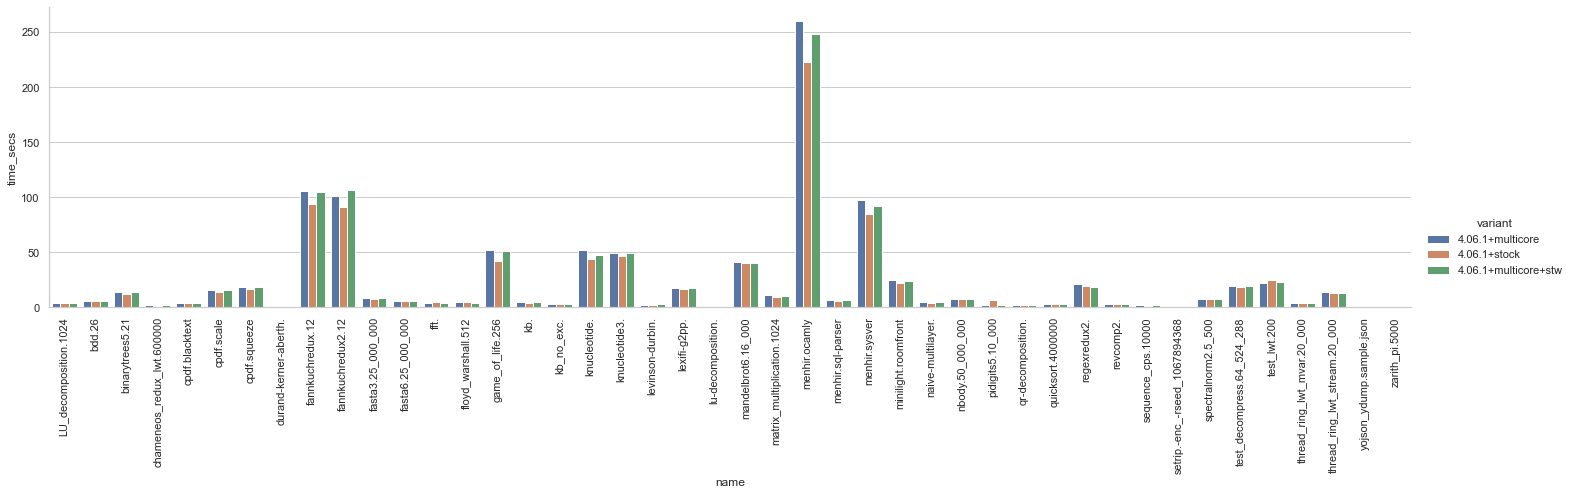

In [7]:
g = sns.catplot (x='name', y='time_secs', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

In [8]:
# returns a dictionary with {key = name : value : metric}
# the metric corresponds to the variant
def create_column(df, variant, metric):
    df = pd.DataFrame.copy(df)
    variant_metric_name = list([ zip(df[metric], df[x], df['name']) 
              for x in df.columns.array if x == "variant" ][0])
    name_metric = {n:t for (t, v, n) in variant_metric_name if v == variant}
#     print(name_metric)
    return name_metric

def add_display_name(df,variant, metric):
    name_metric = create_column(pd.DataFrame.copy(df), variant, metric)
#     print(name_metric)
    disp_name = [name+" ("+str(round(name_metric[name], 2))+")" for name in df["name"]]
    df["display_name"] = pd.Series(disp_name, index=df.index)
    return df

def normalise(df,variant,topic,additionalTopics=[]):
    df = add_display_name(df,variant,topic)
    df = df.sort_values(["name","variant"])
    grouped = df.filter(items=['name',topic,'variant','display_name']+additionalTopics).groupby('variant')
    ndata_frames = []
    for group in grouped:
        (v,data) = group
        if(v != variant):
            data['b'+topic] = grouped.get_group(variant)[topic].values
            data[['n'+topic]] = data[[topic]].div(grouped.get_group(variant)[topic].values, axis=0)
            for t in additionalTopics:
#                 print(variant, t)
                data[[t]] = grouped.get_group(variant)[t].values
            ndata_frames.append(data)
    df = pd.concat (ndata_frames)
    return df

def plot_normalised(df,variant,topic):
    df = pd.DataFrame.copy(df)
    df.sort_values(by=[topic],inplace=True)
    df[topic] = df[topic] - 1
    g = sns.catplot (x="display_name", y=topic, hue='variant', data = df, kind ='bar', aspect=4, bottom=1)
    g.set_xticklabels(rotation=90)
    g.ax.legend(loc=8)
    g._legend.remove()
    g.ax.set_xlabel("Benchmarks")
    return g
    # g.ax.set_yscale('log')

<ipython-input-8-890d57e0b3eb>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)
<ipython-input-8-890d57e0b3eb>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['b'+topic] = grouped.get_group(variant)[topic].values
/home/sk/.local/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

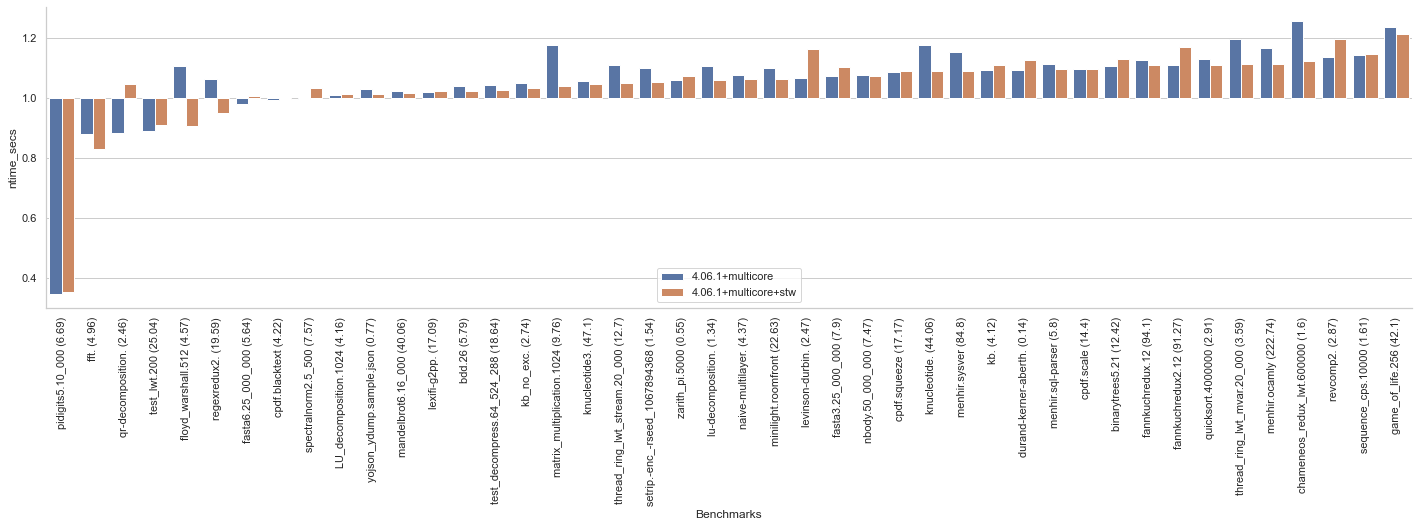

In [9]:
ndf = normalise(df,'4.06.1+stock','time_secs')
plot_normalised(ndf,'4.06.1+stock','ntime_secs')

## Top heap words

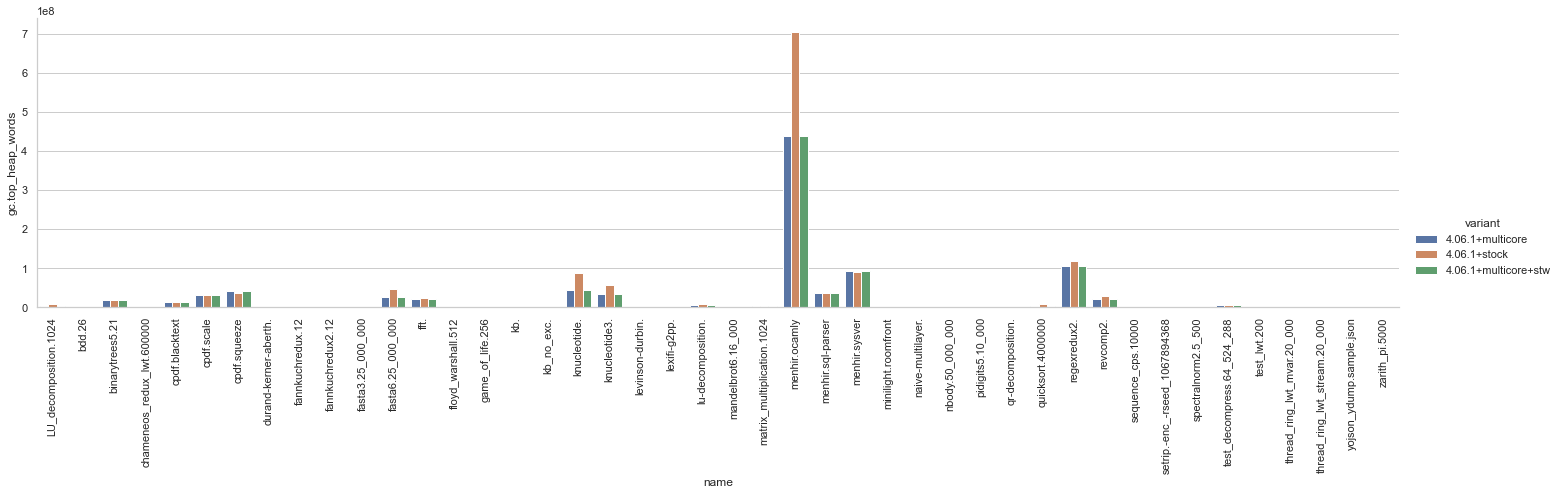

In [10]:
g = sns.catplot (x='name', y='gc.top_heap_words', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

<ipython-input-8-890d57e0b3eb>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)
<ipython-input-8-890d57e0b3eb>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['b'+topic] = grouped.get_group(variant)[topic].values


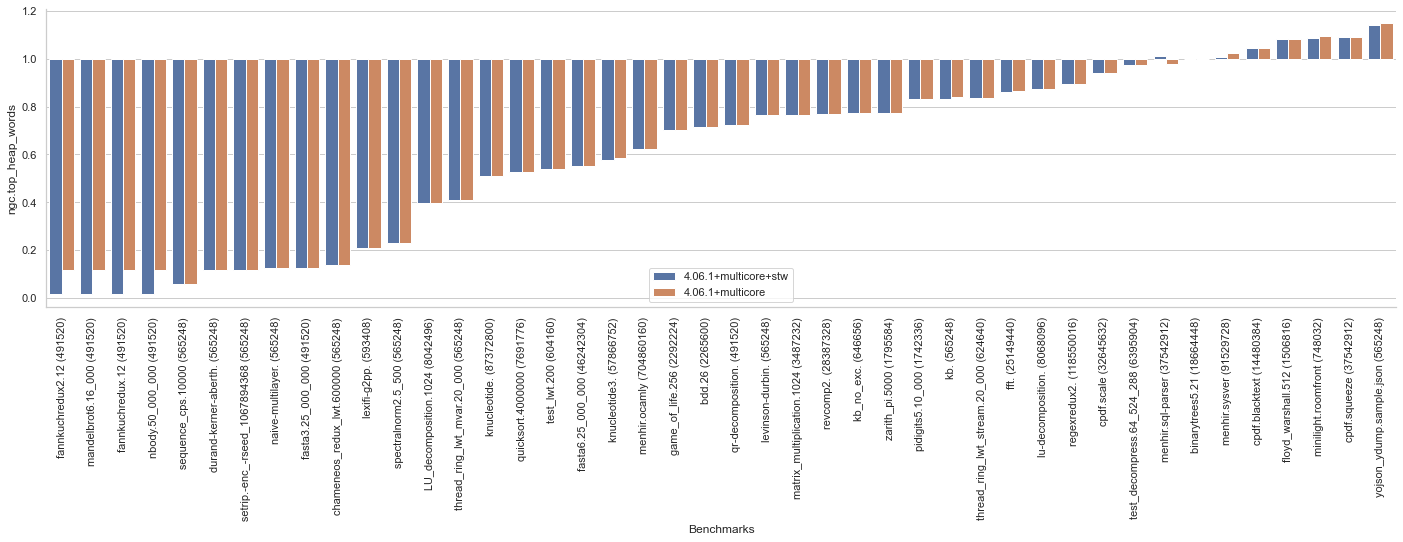

In [11]:
ndf = normalise(df,'4.06.1+stock','gc.top_heap_words')
plot_normalised(ndf,'4.06.1+stock','ngc.top_heap_words')

## Max RSS (KB)

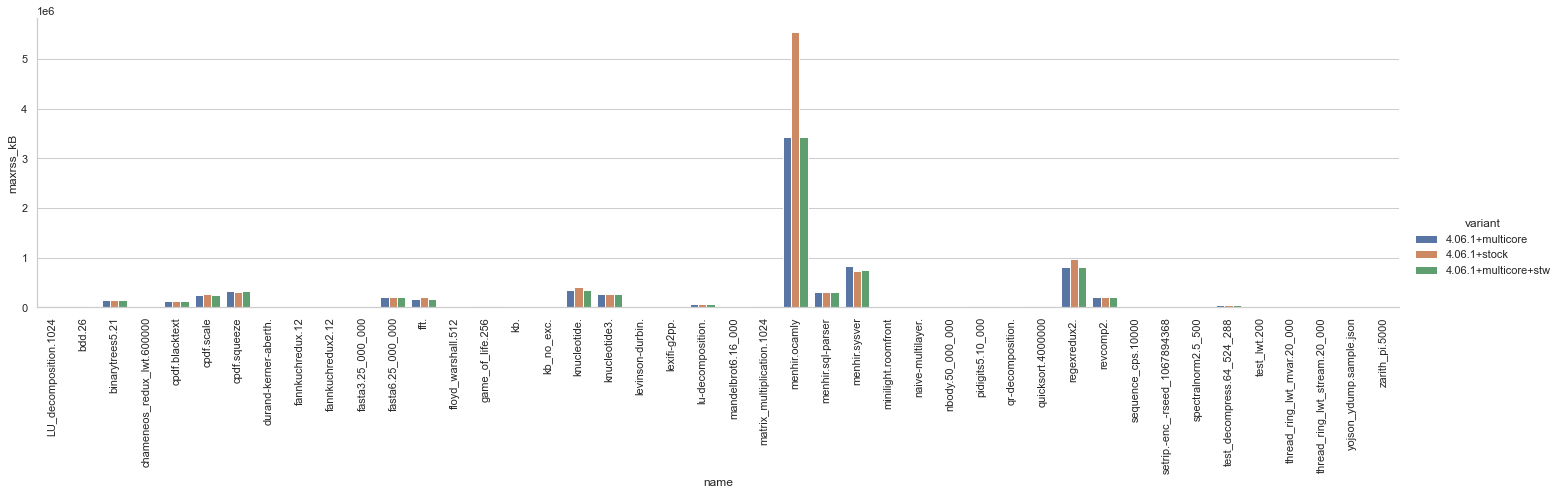

In [12]:
g = sns.catplot (x='name', y='maxrss_kB', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

<ipython-input-8-890d57e0b3eb>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)
<ipython-input-8-890d57e0b3eb>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['b'+topic] = grouped.get_group(variant)[topic].values


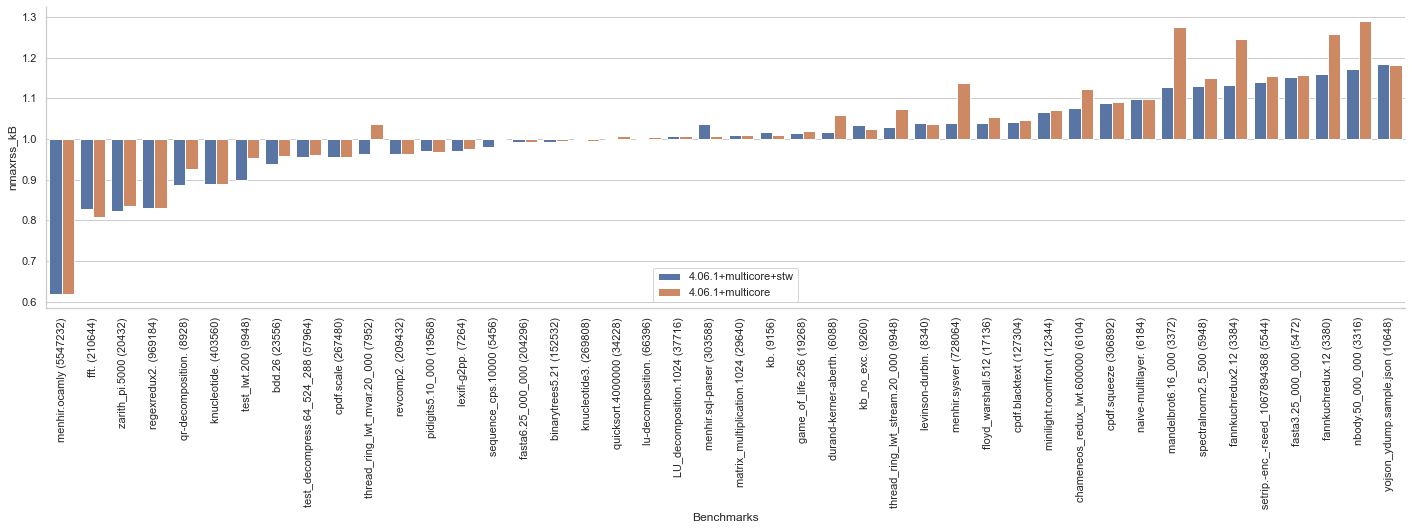

In [13]:
ndf = normalise(df,'4.06.1+stock','maxrss_kB')
plot_normalised(ndf,'4.06.1+stock','nmaxrss_kB')

## Major Collections

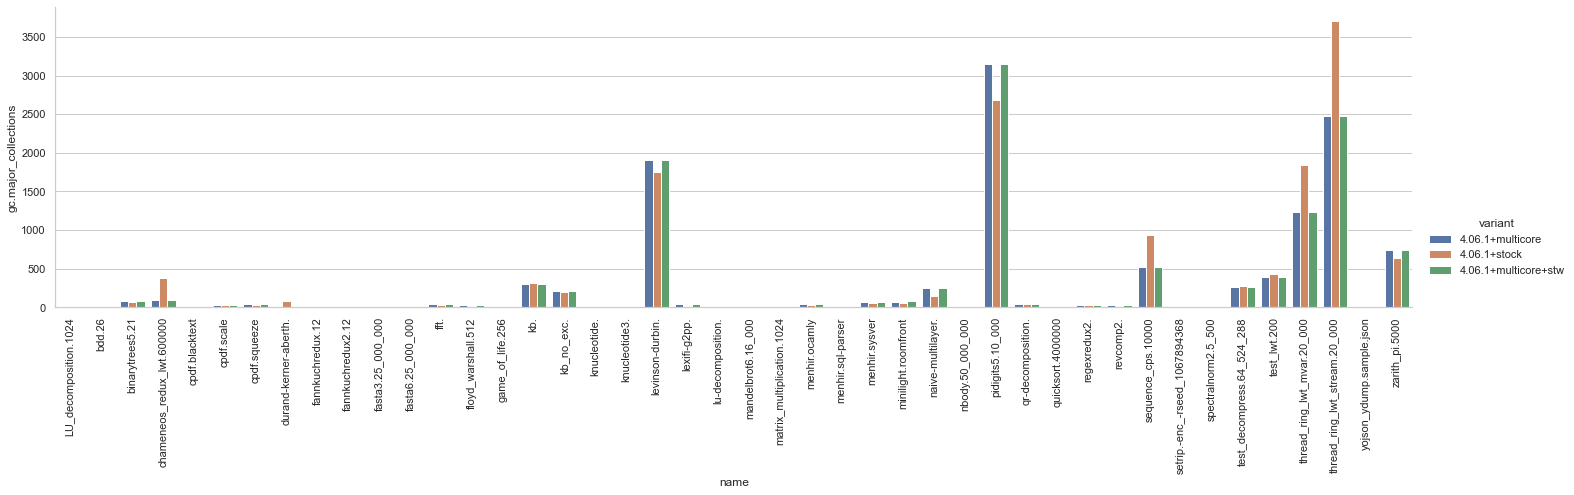

In [14]:
g = sns.catplot (x='name', y='gc.major_collections', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

<ipython-input-8-890d57e0b3eb>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)
<ipython-input-8-890d57e0b3eb>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['b'+topic] = grouped.get_group(variant)[topic].values


,name,gc.major_collections,variant,display_name,bgc.major_collections,ngc.major_collections
9,LU_decomposition.1024,2,4.06.1+multicore,LU_decomposition.1024 (1),1,2.000000
27,bdd.26,10,4.06.1+multicore,bdd.26 (9),9,1.111111
33,binarytrees5.21,81,4.06.1+multicore,binarytrees5.21 (64),64,1.265625
26,chameneos_redux_lwt.600000,94,4.06.1+multicore,chameneos_redux_lwt.600000 (381),381,0.246719
25,cpdf.blacktext,17,4.06.1+multicore,cpdf.blacktext (13),13,1.307692
30,cpdf.scale,34,4.06.1+multicore,cpdf.scale (27),27,1.259259
34,cpdf.squeeze,40,4.06.1+multicore,cpdf.squeeze (33),33,1.212121
20,durand-kerner-aberth.,21,4.06.1+multicore,durand-kerner-aberth. (85),85,0.247059
23,fannkuchredux.12,0,4.06.1+multicore,fannkuchredux.12 (0),0,NaN
22,fannkuchredux2.12,0,4.06.1+multicore,fannkuchredux2.12 (0),0,NaN


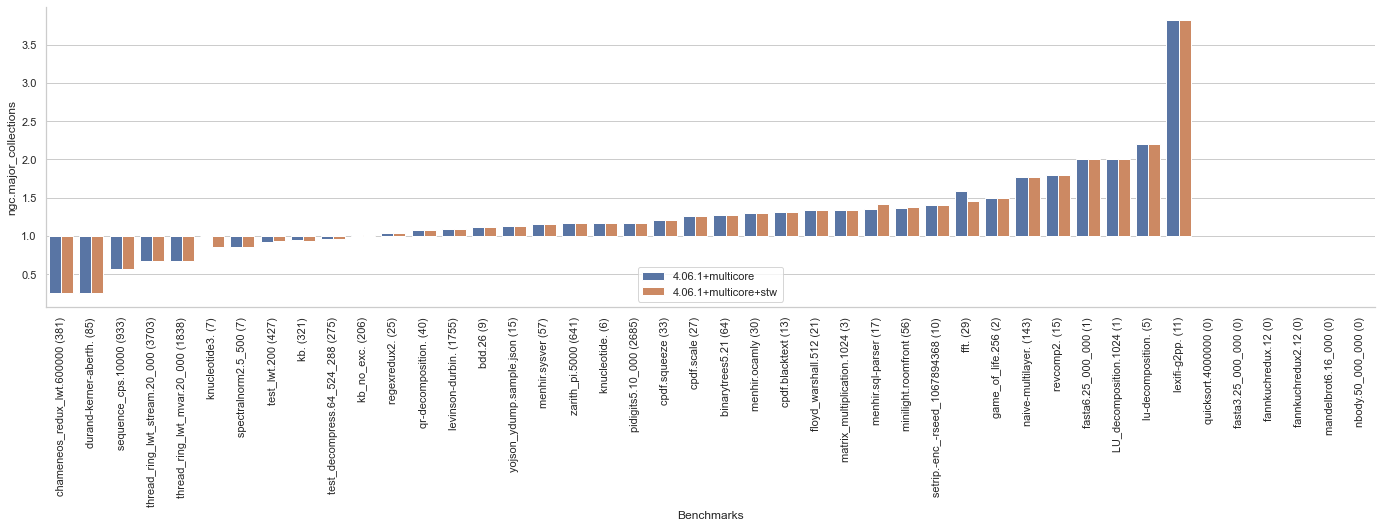

In [15]:
ndf = normalise(df,'4.06.1+stock','gc.major_collections')
plot_normalised(ndf,'4.06.1+stock','ngc.major_collections')
ndf

## Major words

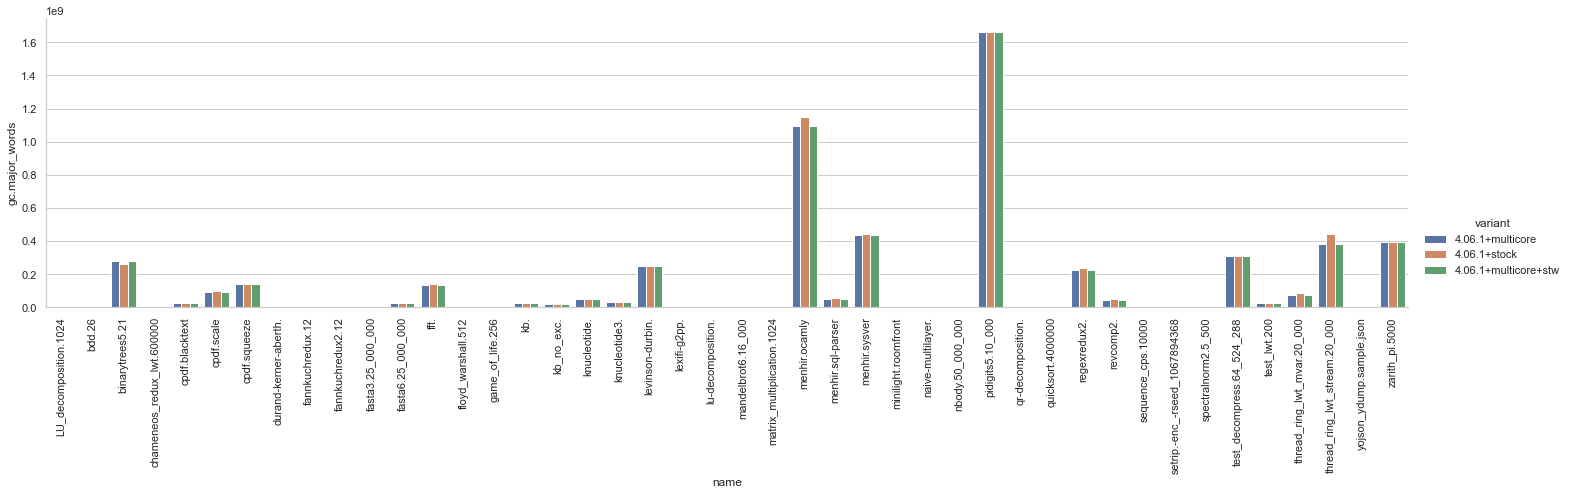

In [16]:
g = sns.catplot (x='name', y='gc.major_words', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

<ipython-input-8-890d57e0b3eb>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)
<ipython-input-8-890d57e0b3eb>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['b'+topic] = grouped.get_group(variant)[topic].values
/home/sk/.local/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

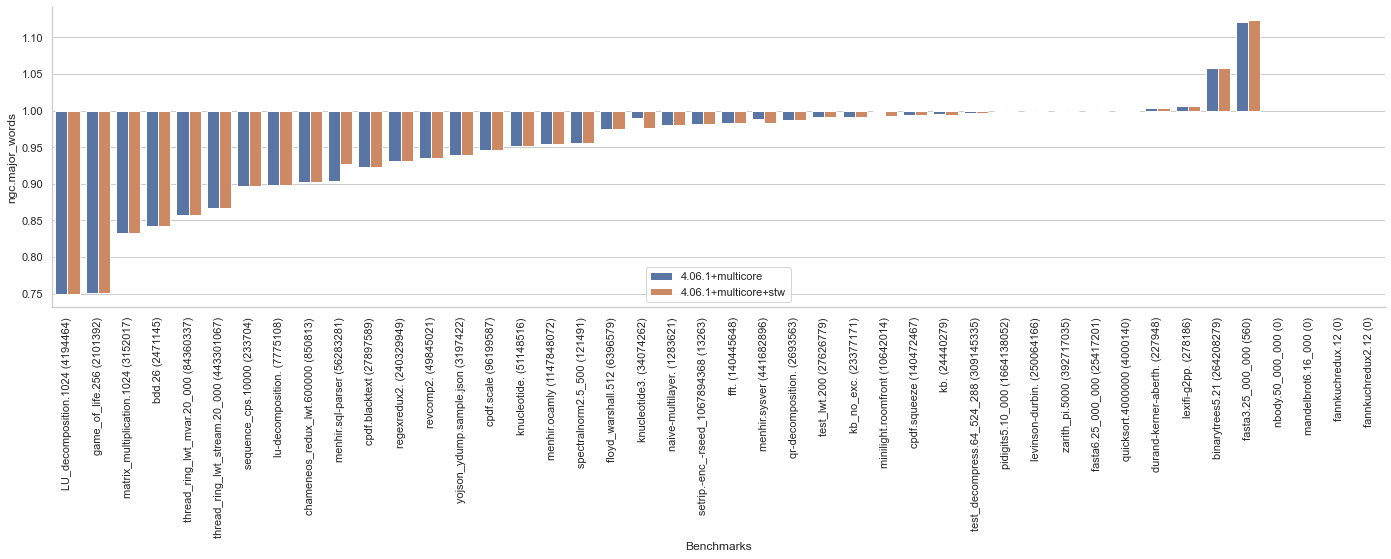

In [17]:
ndf = normalise(df,'4.06.1+stock','gc.major_words')
plot_normalised(ndf,'4.06.1+stock','ngc.major_words')

## Minor Collections

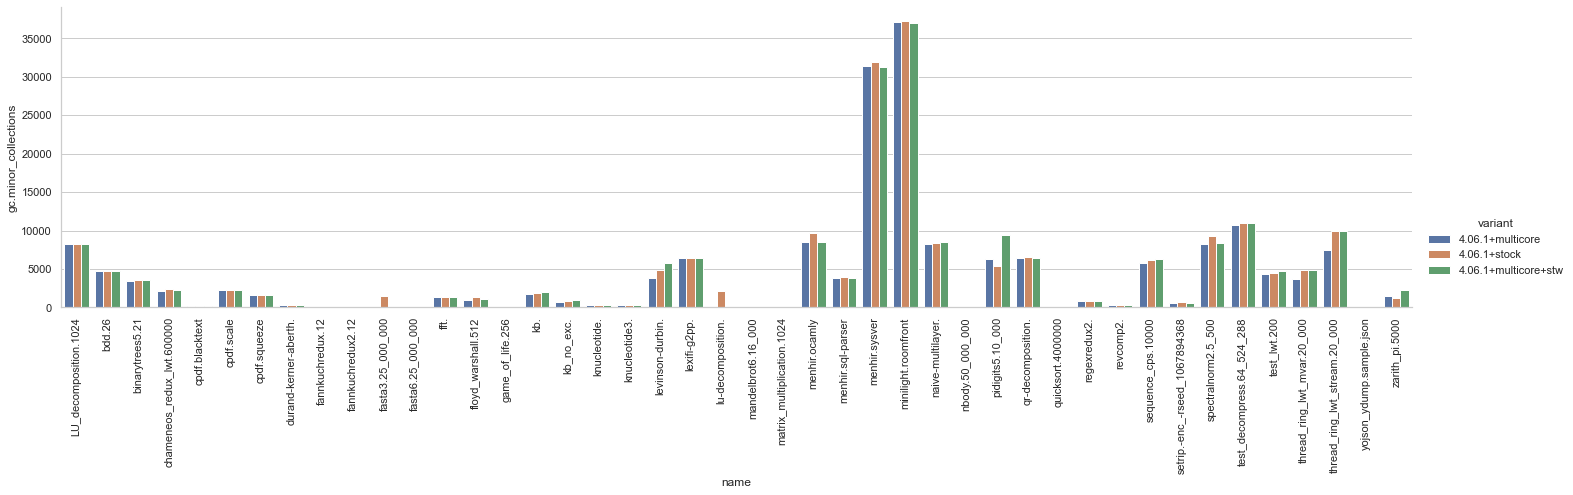

In [18]:
g = sns.catplot (x='name', y='gc.minor_collections', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

<ipython-input-8-890d57e0b3eb>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)
<ipython-input-8-890d57e0b3eb>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['b'+topic] = grouped.get_group(variant)[topic].values


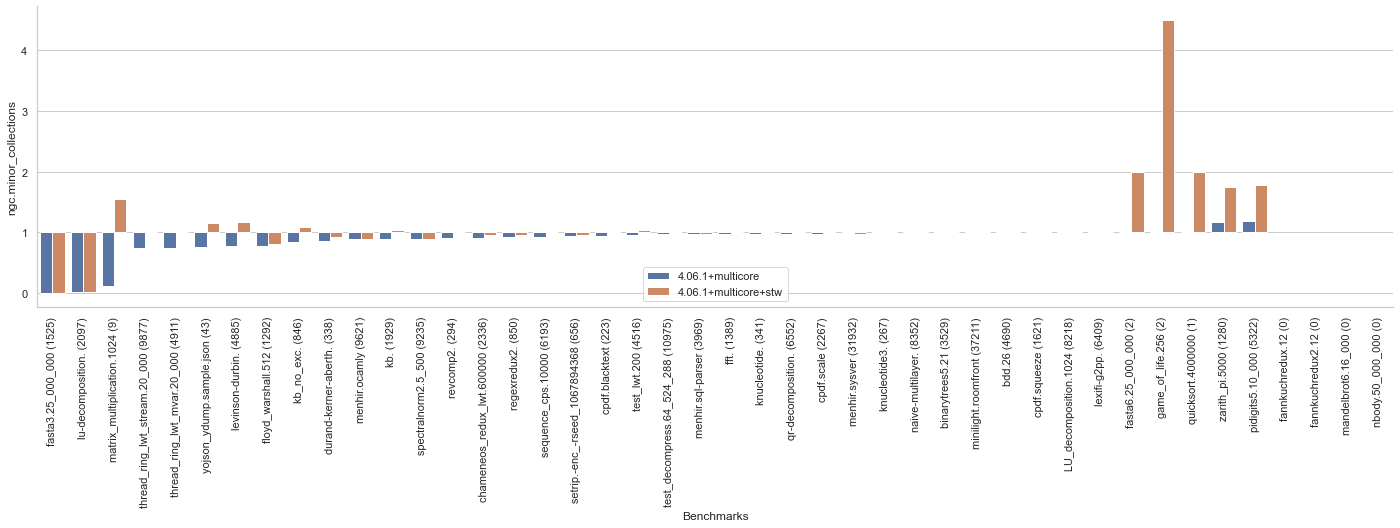

In [19]:
ndf = normalise(df,'4.06.1+stock','gc.minor_collections')
plot_normalised(ndf,'4.06.1+stock','ngc.minor_collections')

# Latency

In [20]:
data_frames = []

for file in glob.glob("*.pausetimes_*.bench"):
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        ldf = pdjson.json_normalize(data)
        ldf['variant'] = file.replace(".pausetimes_multicore.bench","").replace(".pausetimes_trunk.bench","")
        data_frames.append(ldf)

df2 = pd.concat(data_frames, sort=False)
df2 = df2.sort_values(['name'])

## Drop some benchmarks
df2 = df2[(df2.name != 'alt-ergo.fill.why') & #multicore version does not exist
        (df2.name != 'alt-ergo.yyll.why') & #multicore version does not exist
        (df2.name != 'frama-c.slevel') &    #multicore version does not exist
        (df2.name != 'js_of_ocaml.frama-c_byte') &    #multicore version does not exist
        (df2.name != 'cpdf.merge')]         #Not a macro benchmark. Will be removed from subsequent runs.
df2.count()
latency_df = df2
df2

<ipython-input-20-838a2c18826b>:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  ldf = pdjson.json_normalize(data)


,name,mean_latency,max_latency,distr_latency,variant
19,LU_decomposition.1024,6.244134e+03,152543,"[6021, 6047, 6067, 6084, 6100, 6118, 6139, 617...",4.06.1+multicore+stw+pausetimes
28,LU_decomposition.1024,1.415596e+03,16863,"[480, 502, 534, 822, 859, 887, 928, 3305, 3681...",4.06.1+stock+instrumented
19,LU_decomposition.1024,1.430908e+03,32065,"[1240, 1259, 1271, 1282, 1293, 1305, 1321, 134...",4.06.1+multicore+pausetimes
45,bdd.26,2.204888e+04,7787502,"[6783, 6836, 6880, 6919, 6958, 7006, 7069, 718...",4.06.1+multicore+stw+pausetimes
10,bdd.26,9.684711e+03,5184330,"[526, 571, 665, 1696, 1809, 1898, 2022, 3889, ...",4.06.1+stock+instrumented
45,bdd.26,1.790224e+04,7579387,"[1986, 2041, 2082, 2125, 2167, 2214, 2277, 238...",4.06.1+multicore+pausetimes
40,binarytrees5.21,1.123347e+06,94869040,"[2027, 4622, 8625, 24961, 77237, 311440, 12281...",4.06.1+stock+instrumented
3,binarytrees5.21,2.604144e+06,21265507,"[6814, 12475, 20656, 42591, 150718, 711218, 30...",4.06.1+multicore+stw+pausetimes
3,binarytrees5.21,2.513044e+06,20855307,"[1574, 5885, 14417, 33346, 131335, 664302, 277...",4.06.1+multicore+pausetimes
8,chameneos_redux_lwt.600000,1.389608e+04,174618,"[2632, 5589, 9552, 12634, 15580, 17543, 18135,...",4.06.1+stock+instrumented


The latency distributions `distr_latency` are a list of latencies at `[10,20,30,40,50,60,70,80,90,95,99,99.9]`th percentiles.

## Max latency

In [21]:
df2.filter(["name","variant","max_latency"])

,name,variant,max_latency
19,LU_decomposition.1024,4.06.1+multicore+stw+pausetimes,152543
28,LU_decomposition.1024,4.06.1+stock+instrumented,16863
19,LU_decomposition.1024,4.06.1+multicore+pausetimes,32065
45,bdd.26,4.06.1+multicore+stw+pausetimes,7787502
10,bdd.26,4.06.1+stock+instrumented,5184330
45,bdd.26,4.06.1+multicore+pausetimes,7579387
40,binarytrees5.21,4.06.1+stock+instrumented,94869040
3,binarytrees5.21,4.06.1+multicore+stw+pausetimes,21265507
3,binarytrees5.21,4.06.1+multicore+pausetimes,20855307
8,chameneos_redux_lwt.600000,4.06.1+stock+instrumented,174618


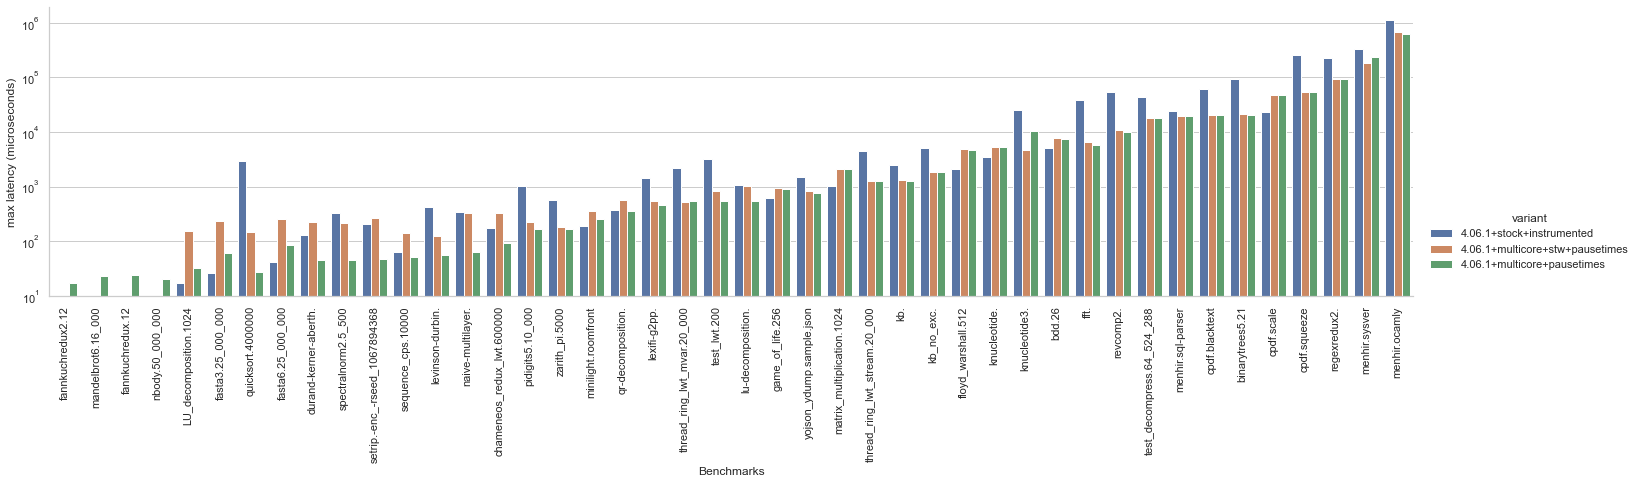

In [22]:
def plotLatencyAt(df,at,aspect):
    fdf = df.filter(["name","variant",at + "_latency"])
    fdf.sort_values(by=[at + '_latency'],inplace=True)
    fdf[at + "_latency"] = fdf[at + "_latency"] / 1000.0
    g = sns.catplot (x='name', y=at+'_latency', hue='variant', data = fdf, kind ='bar', aspect=aspect)
    g.set_xticklabels(rotation=90)
    g.ax.set_ylabel(at + " latency (microseconds)")
    g.ax.set_xlabel("Benchmarks")
    g.ax.set_yscale('log')
    return g

plotLatencyAt(df2,"max",4)

## 99.9th percentile latency

/home/sk/.local/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/sk/.local/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


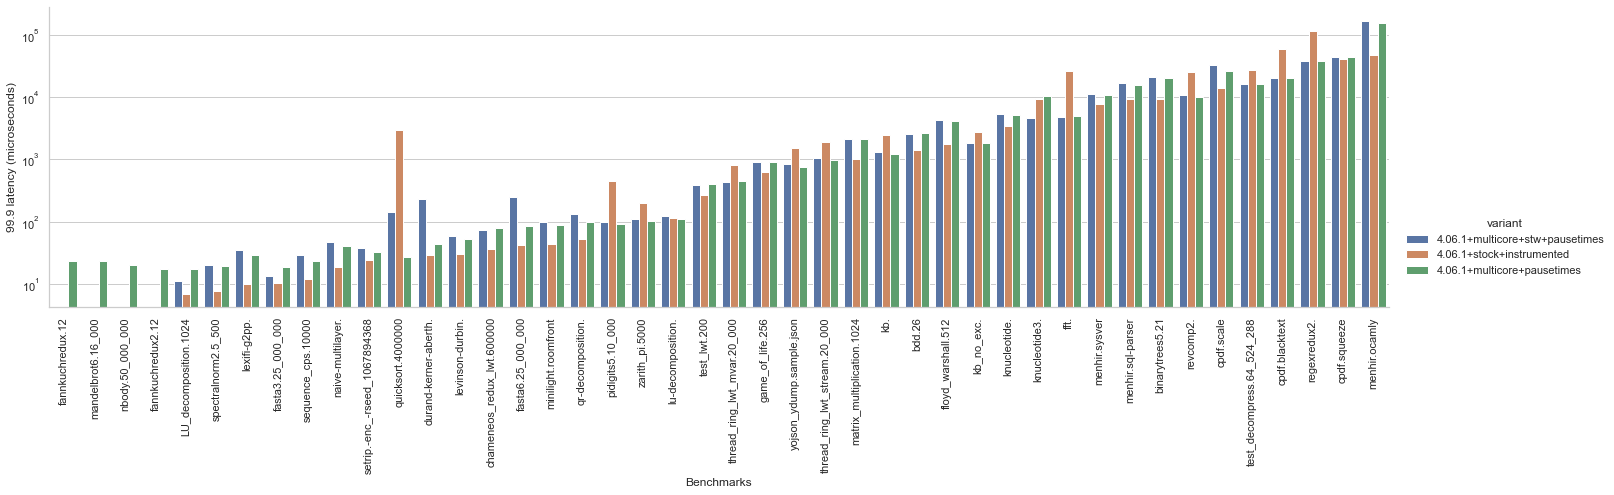

In [23]:
def getLatencyAt(df,percentile,idx):
    groups = df.groupby('variant')
    ndfs = []
    for group in groups:
        (v,df) = group
        for i, row in df.iterrows():
            df.at[i,percentile+"_latency"] = list(df.at[i,"distr_latency"])[idx]
        ndfs.append(df)
    return pd.concat(ndfs)

df2 = getLatencyAt(df2,"99.9",-1)
plotLatencyAt(df2,"99.9",4)

## 99th percentile latency

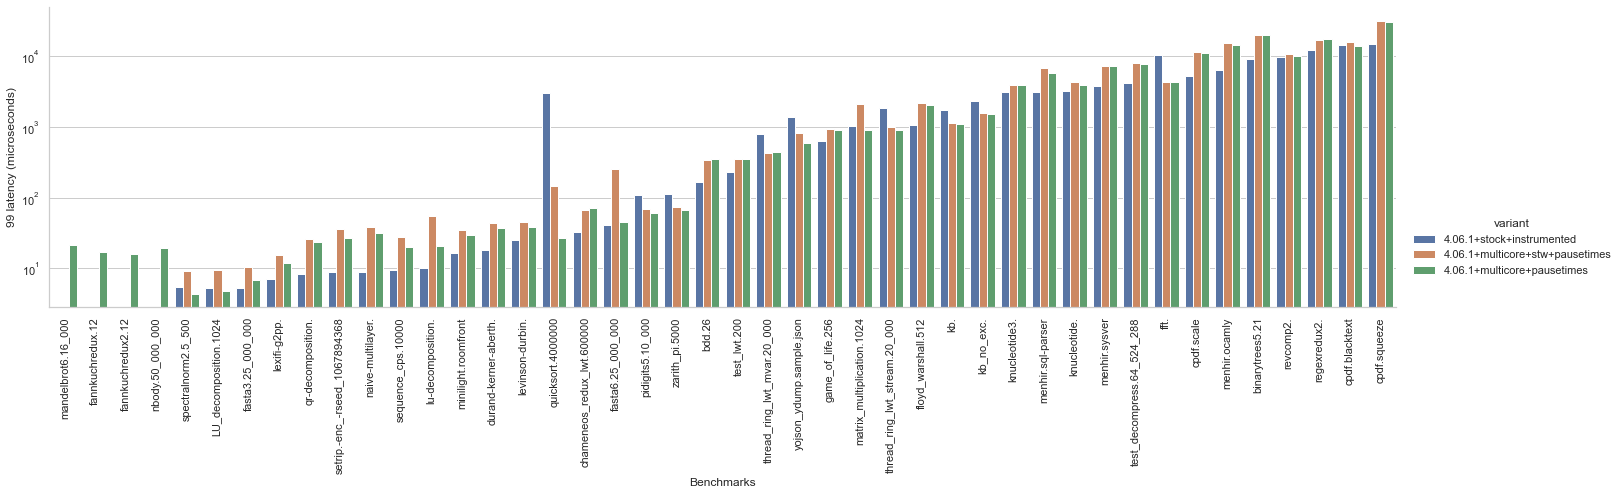

In [24]:
df2 = getLatencyAt(df2,"99",-2)
plotLatencyAt(df2,"99",4)